This notebook loads the coherence plots for small full res unwrapped region. Calculates for each pixel how much time is spent below a coh threshold, saves the results.

This notebook: <br>
1. Loads in coherence files
2. loops through pixels and calculates how much time was spent below a coherence threshold 
3. does this for a few coherence threshold values
4. saves the results.

This notebook was written on 3-1-23

***

In [1]:
# import stuff
import os,sys
import glob
import pandas
from osgeo import gdal
import datetime 
from datetime import datetime
from datetime import timedelta
from dateutil import parser
import numpy as np
from scipy.ndimage import gaussian_filter
from scipy.stats import skew
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.patches import Rectangle
%matplotlib  widget

Load coherence maps.

In [2]:
saveDir = '/data/ocp4/LagunaSalada/2_coherence/coh_tip_LS_all_igrams/'
datesDir = '/data/ocp4/LagunaSalada/cropped_9000_1800_18000_3600/'
dx = 3000
dy = 750
# load in dates, make sure they are in order
dates = [os.path.basename(x) for x in glob.glob(datesDir+"SLC_vh/2*")]; dates = sorted(dates)
nd = len(dates); numIgrams = nd-1
coh = np.ndarray((numIgrams,dy,dx),dtype='float')
for i in range(numIgrams): #range(numIgrams)
    date1=dates[i]
    date2=dates[i+1]
    file_name = 'coh_'+str(date1)+'_'+str(date2)+'.r4'
    f1 = gdal.Open(saveDir+file_name, gdal.GA_ReadOnly)
    coh[i] = f1.ReadAsArray()
f1 = None
print('Coh maps loaded.')

Coh maps loaded.


Set a few threshold values. 

In [17]:
# th = np.arange(0.5,1.0,0.1)
# th = np.append(th, 0.93)

th = [0.6,0.8,0.9,0.93]
print(th)
num_th = len(th)
print('number of thresholds to loop through: '+str(num_th))

[0.6, 0.8, 0.9, 0.93]
number of thresholds to loop through: 4


Loop through pixels, calculate percentage of time spent above threshold values, save it.

In [18]:
time_above_th = np.ndarray((num_th,dy,dx),dtype='float')
for i in range(num_th):
    for y in range(dy):         # dy
        for x in range(dx):     # dx
            coh_temp = coh[:,y,x]
            time_above_th[i,y,x] = (coh_temp>=th[i]).sum()
time_above_th = time_above_th/numIgrams # converts to percentage of dates 
print('Num dates above coh thresholds calculated.')

Num dates above coh thresholds calculated.


Plot them. 

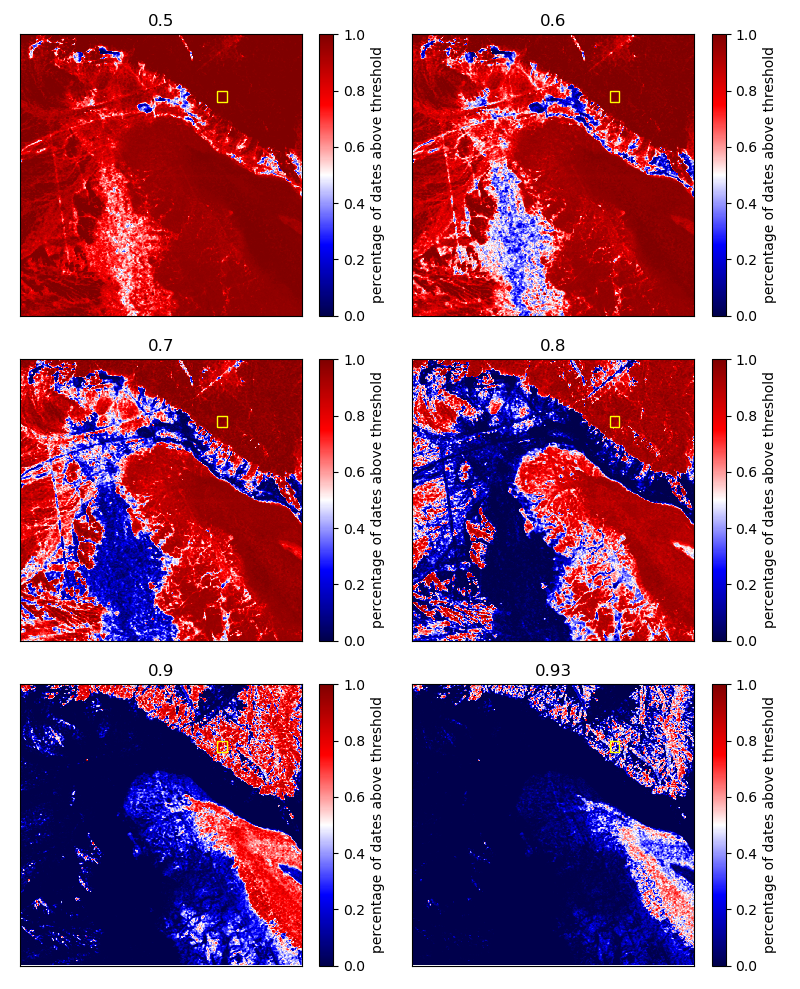

In [16]:
num_rows = int(np.ceil(num_th/2))
plt.figure(figsize=(8,3.3*num_rows),tight_layout=True)
count = 1
for i in range(num_th):
    plt.subplot(num_rows,2,count)
    plt.imshow(time_above_th[i],aspect='auto',cmap='seismic',interpolation='nearest',vmin=0,vmax=1)
    plt.xlim([dx,0]); plt.xticks([]); plt.yticks([])
    plt.gca().add_patch(Rectangle((800,150),100,30,edgecolor='yellow',facecolor='none',linewidth=1))
    plt.colorbar(label='percentage of dates above threshold')
    plt.title(np.round(th[i],3))
    count += 1
plt.show()

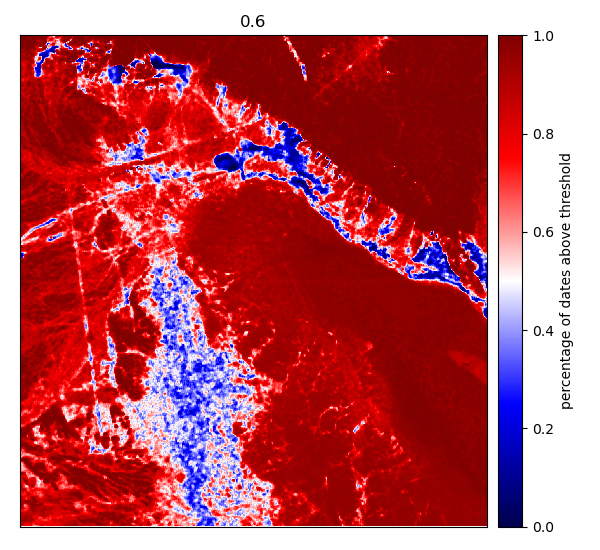

In [32]:
# plots for Geol.Sci.Seminar 3-17-2013
i = 0
plt.figure(figsize=(6,5.5),tight_layout=True)
plt.imshow(time_above_th[i],aspect='auto',cmap='seismic',interpolation='nearest',vmin=0,vmax=1)
plt.xlim([dx,0]); plt.xticks([]); plt.yticks([])
#plt.gca().add_patch(Rectangle((800,150),100,30,edgecolor='yellow',facecolor='none',linewidth=3.5))
plt.colorbar(pad = 0.02,label='percentage of dates above threshold')
plt.title(np.round(th[i],3))
plt.show()

Calculate average coherence at each pixel. 

In [6]:
avg_coh = np.ndarray((dy,dx),dtype='float')
for y in range(dy):         # dy
    for x in range(dx):     # dx
        avg_coh[y,x] = np.mean(coh[:,y,x])
print('Avg coh for each pixel calculated.')

Avg coh for each pixel calculated.


Plot it.

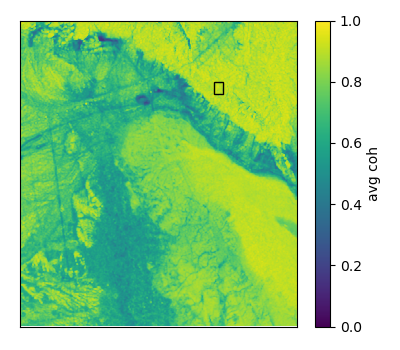

In [7]:
plt.figure(figsize=(4,3.5),tight_layout=True)
plt.imshow(avg_coh,aspect='auto',interpolation='nearest',vmin=0,vmax=1)
plt.xlim([dx,0]); plt.xticks([]); plt.yticks([])
plt.colorbar(label='avg coh')
plt.gca().add_patch(Rectangle((800,150),100,30,edgecolor='k',facecolor='none',linewidth=1))
plt.show()

In [8]:
avg_coh_masked = np.ma.masked_where(avg_coh<0.85,avg_coh)

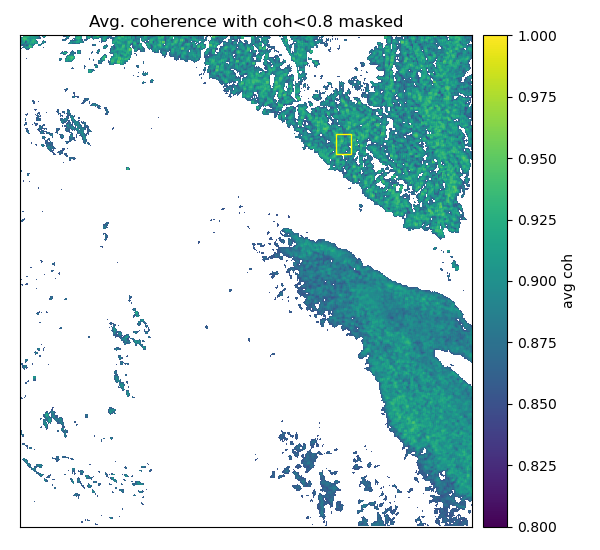

In [36]:
plt.figure(figsize=(6,5.5),tight_layout=True)
plt.imshow(avg_coh_masked,aspect='auto',interpolation='nearest',vmin=0.80,vmax=1)
plt.xlim([dx,0]); plt.xticks([]); plt.yticks([])
plt.gca().add_patch(Rectangle((800,150),100,30,edgecolor='yellow',facecolor='none',linewidth=1))
plt.colorbar(label='avg coh',pad=0.02)
plt.title('Avg. coherence with coh<0.8 masked')
plt.show()

IDEA: What if I high pass filter each unwrapped, full res igram and then calculate the std. dev. of each time series (how much does it "move" w/out atm coming in to play) then pick out pixels where that std. dev. value is < threshold value? 

ANOTHER IDEA: for time series, what if I impose a constraint that total cumulative disp = 0 in whole time period. Assume during all rain events where coherence < threshold value, that the surface is doing the same thing each time (going down/up a little bit). To make up for the overall deficit, how much would the ground need to uplift/subside during each storm? Calculate it for each pixel, really only matters for LS so hopefully pixels in LS would show larger magnitude values and hoepfully they are positive (subsidence during rain bc evaporite crystal dissolution)